## Demand Forecasting and Inventory Optimization 

Demand Forecasting means estimating future customer demand for a product or service based on historical data and relevant factors. Inventory Optimization is the strategic management of inventory levels to ensure that the right amount of goods is available at the right time to meet customer demand while minimizing costs. 

Demand Forecasting involves predicting the quantity and pattern of customer orders, which is crucial for businesses to efficiently allocate resources, manage inventory, and plan production. Accurate demand forecasting enables companies to meet customer needs, avoid overstocking or understocking, and optimize their supply chain operations.

Inventory Optimization aims to strike a balance between having sufficient stock to meet demand without carrying excess inventory that ties up capital and storage space. Effective inventory optimization helps businesses reduce carrying costs, improve cash flow, and enhance customer satisfaction

These concepts are especially relevant in retail, manufacturing, and distribution, where managing supply and demand dynamics is essential for profitability and customer satisfacti
.


For the task of Demand Forecasting and Inventory Optimization, we can start by gathering historical sales data, customer orders, and relevant external factors like seasonality, promotions, and economic trends. Then, we can use appropriate forecasting models like ARIMA, SARIMA, or exponential smoothing for demand forecasting. Then, we can use the demand forecasts to optimize inventory levels by implementing strategies like reorder points, safety stock, and economic order quantity (EOQ) calculations.

Now, let’s import the necessary Python libraries and the dataset:

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.stats.diagnostic import acorr_ljungbox

data = pd.read_csv("demand_inventory.csv")
print(data.head())

   Unnamed: 0        Date Product_ID  Demand  Inventory
0           0  2023-06-01         P1      51       5500
1           1  2023-06-02         P1     141       5449
2           2  2023-06-03         P1     172       5308
3           3  2023-06-04         P1      91       5136
4           4  2023-06-05         P1     198       5045


There’s an unnamed column in the dataset. I’ll drop it and move forward:

In [2]:
data = data.drop(columns=['Unnamed: 0'])

Now, let’s visualize the demand over time:

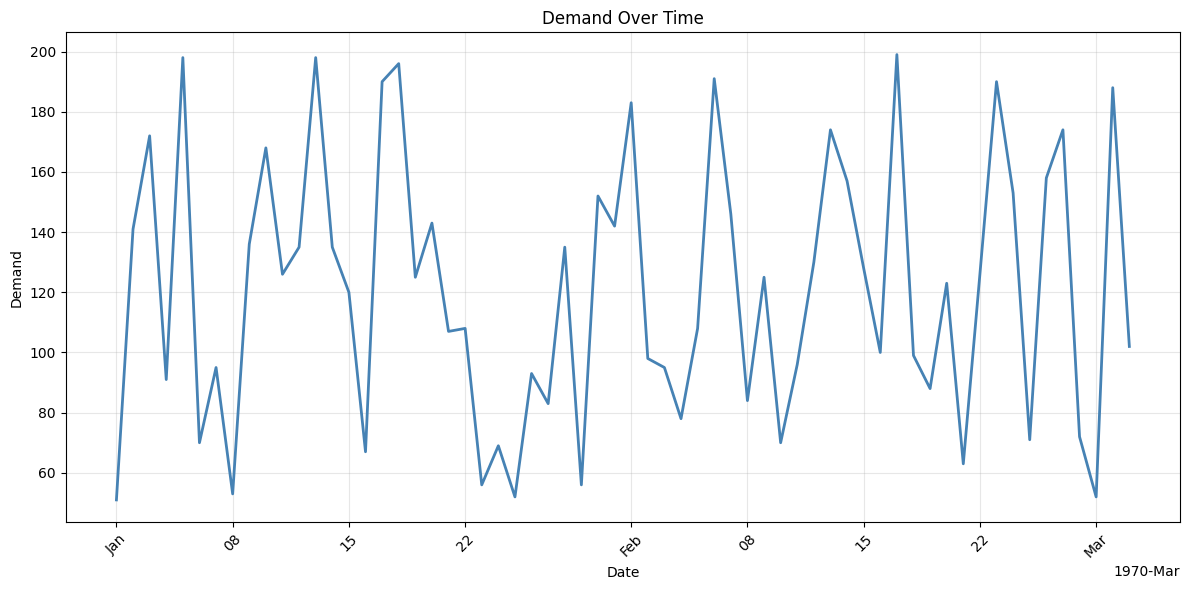

In [4]:
import matplotlib.dates as mdates
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
plt.plot(data['Date'], data['Demand'], linewidth=2, color="steelblue")

# Titles
plt.title("Demand Over Time")
plt.xlabel("Date")
plt.ylabel("Demand")

# Format x-axis ticks
plt.xticks(rotation=45)  # rotate labels
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.AutoDateLocator())
ax.xaxis.set_major_formatter(mdates.ConciseDateFormatter(ax.xaxis.get_major_locator()))

plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

Now, let’s visualize the inventory over time:

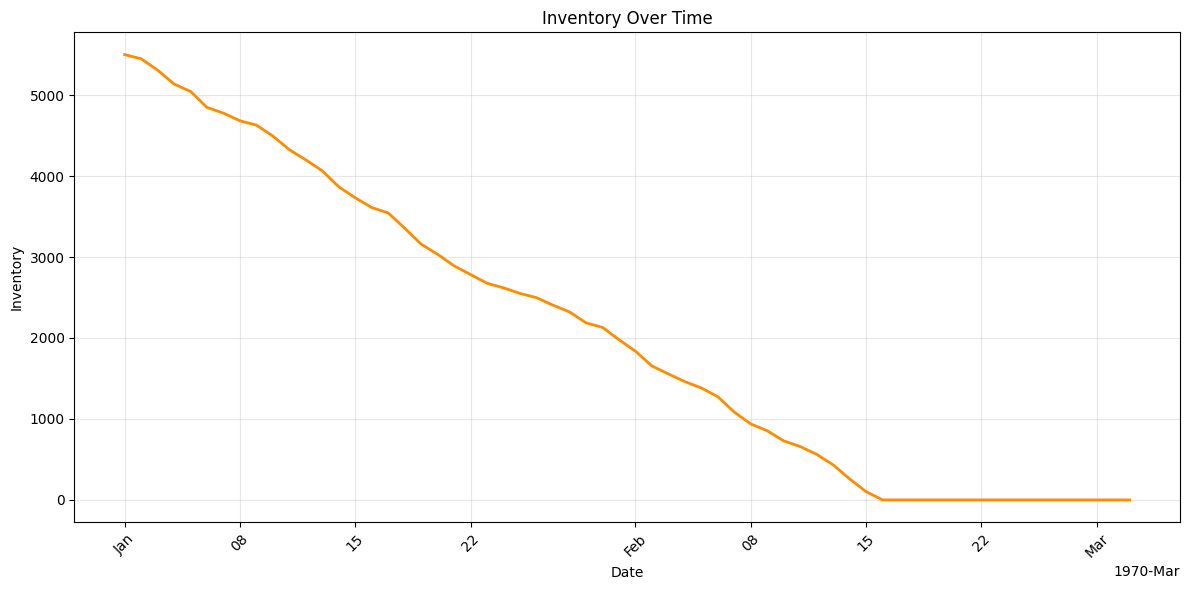

In [5]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

plt.figure(figsize=(12,6))
plt.plot(data['Date'], data['Inventory'], linewidth=2, color="darkorange")

# Titles
plt.title("Inventory Over Time")
plt.xlabel("Date")
plt.ylabel("Inventory")

# Format x-axis nicely
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.AutoDateLocator())
ax.xaxis.set_major_formatter(mdates.ConciseDateFormatter(ax.xaxis.get_major_locator()))
plt.xticks(rotation=45)

plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

## Demand Forecasting:

I can see seasonal patterns in the demand. We can forecast the demand using SARIMA. Let’s first calculate the value of p and q using ACF and PACF plots:

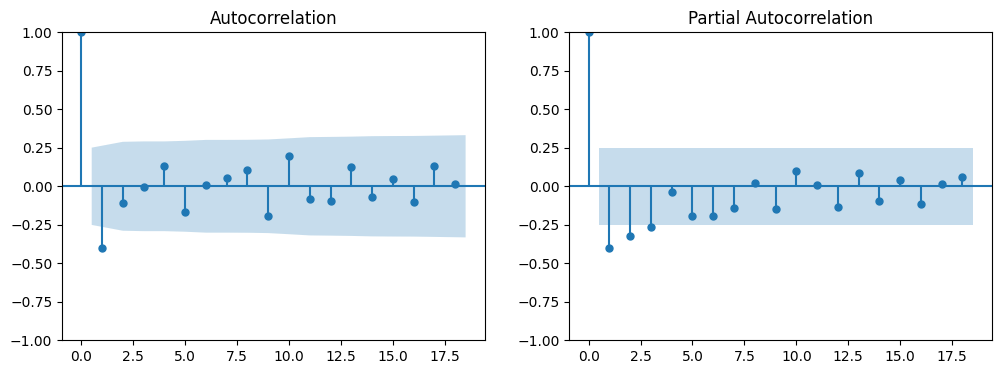

In [7]:
data['Date'] = pd.to_datetime(data['Date'],
                                     format='mixed')
time_series = data.set_index('Date')['Demand']

differenced_series = time_series.diff().dropna()

# Plot ACF and PACF of differenced time series
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
plot_acf(differenced_series, ax=axes[0])
plot_pacf(differenced_series, ax=axes[1])
plt.show()

The value of p, d, and q will be 1, 1, 1 here.Now, let’s train the model and forecast demand for the next ten days:

In [8]:
order = (1, 1, 1)
seasonal_order = (1, 1, 1, 2) #2 because the data contains a time period of 2 months only
model = SARIMAX(time_series, order=order, seasonal_order=seasonal_order)
model_fit = model.fit(disp=False)

future_steps = 10
predictions = model_fit.predict(len(time_series), len(time_series) + future_steps - 1)
predictions = predictions.astype(int)
print(predictions)

2023-08-02    117
2023-08-03    116
2023-08-04    130
2023-08-05    114
2023-08-06    128
2023-08-07    115
2023-08-08    129
2023-08-09    115
2023-08-10    129
2023-08-11    115
Freq: D, Name: predicted_mean, dtype: int32


C:\Users\chaitna\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\chaitna\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



## Inventory Optimization:

Now let’s see how we can optimize inventory according to the forecasted demand for the next ten days:

In [9]:
# Create date indices for the future predictions
future_dates = pd.date_range(start=time_series.index[-1] + pd.DateOffset(days=1), periods=future_steps, freq='D')

# Create a pandas Series with the predicted values and date indices
forecasted_demand = pd.Series(predictions, index=future_dates)

# Initial inventory level
initial_inventory = 5500

# Lead time (number of days it takes to replenish inventory) 
lead_time = 1 # it's different for every business, 1 is an example

# Service level (probability of not stocking out)
service_level = 0.95 # it's different for every business, 0.95 is an example

# Calculate the optimal order quantity using the Newsvendor formula
z = np.abs(np.percentile(forecasted_demand, 100 * (1 - service_level)))
order_quantity = np.ceil(forecasted_demand.mean() + z).astype(int)

# Calculate the reorder point
reorder_point = forecasted_demand.mean() * lead_time + z

# Calculate the optimal safety stock
safety_stock = reorder_point - forecasted_demand.mean() * lead_time

# Calculate the total cost (holding cost + stockout cost)
holding_cost = 0.1  # it's different for every business, 0.1 is an example
stockout_cost = 10  # # it's different for every business, 10 is an example
total_holding_cost = holding_cost * (initial_inventory + 0.5 * order_quantity)
total_stockout_cost = stockout_cost * np.maximum(0, forecasted_demand.mean() * lead_time - initial_inventory)

# Calculate the total cost
total_cost = total_holding_cost + total_stockout_cost

print("Optimal Order Quantity:", order_quantity)
print("Reorder Point:", reorder_point)
print("Safety Stock:", safety_stock)
print("Total Cost:", total_cost)

Optimal Order Quantity: 236
Reorder Point: 235.25
Safety Stock: 114.45
Total Cost: 561.8000000000001


Now let’s understand this output one by one:

1. Optimal Order Quantity: 236 – The optimal order quantity refers to the quantity of a product that should be ordered from suppliers when the inventory level reaches a certain point. In this case, an optimal order quantity of 236 units has been calculated.
2. Reorder Point: 235.25 – The reorder point is the inventory level at which a new order should be placed to replenish stock before it runs out. In this case, a reorder point of 235.25 units has been calculated, which means that when the inventory reaches or falls below this level, an order should be placed to replenish stock.
3. Safety Stock: 114.45 – Safety stock is the additional inventory kept on hand to account for uncertainties in demand and supply. It acts as a buffer against unexpected variations in demand or lead time. In this case, a safety stock of 114.45 units has been calculated, which helps ensure that there’s enough inventory to cover potential fluctuations in demand or lead time.
4. Total Cost: 561.80 – The total cost represents the combined costs associated with inventory management. In this case, the total cost has been calculated as approximately 561.80 units based on the order quantity, reorder point, safety stock, and associated costs.

By analyzing these values, we can make informed decisions about how much inventory to order and when to place orders to ensure a smooth supply chain and customer satisfaction while minimizing costs.